#  과제2-1. 수어번역기 모델링 및 추적(개인과제)

## 1.환경준비

### (1) 라이브러리 로딩

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

import mlflow
import mlflow.keras

In [154]:
np.set_printoptions(linewidth=np.inf)

* 함수 만들기

In [155]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터로딩

#### 1) 데이터 가져오기
* 제공 받은 데이터를 여러분의 구글드라이브 적절한 위치에 업로드 합니다.
    * 가능하면, 구글드라이브 첫 경로 밑에 폴더를 만들고 업로드 하기를 권장합니다.

In [156]:
path = r'C:\Users\user\MLOps\data\sign_language.csv'
file = r'data\sign_language.csv'

data = pd.read_csv(path, encoding='cp949')
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [157]:
data.shape

(8000, 785)

#### 2) class names
* label이 0 ~ 27 까지의 숫자로 표현됩니다.
* 수어 중에서 J(9) 와 Z(27)는 손을 움직이면서 표현해야 하므로, 여기서는 제외합니다.
* 숫자로 레이블링 된 것을, 나중에 문자 변환하기 위해 문자로 된 리스트를 생성합니다.

In [158]:
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

(26,
 array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype='<U1'))

### (3) mlflow 추적 준비
* 서버 주소 사용

In [159]:
# http://mlflow.carpediem.so
mlflow_uri = "http://mlflow.carpediem.so"
mlflow.set_tracking_uri(mlflow_uri)

### (4) 새 실험 생성
* 팀에서 1명만 새 실험 생성 
    * exp_## (## : 팀 번호)
    * 팀원들과 exp id 공유

In [160]:
#exp_id = mlflow.create_experiment("exp_11")
#exp_id

## 2.데이터 준비

### (1) 데이터 분할1 : x, y 나누기

In [161]:
# x, y 분리
target = 'label'
x = data.drop(target, axis=1)
y = data[target]

# 데이터 크기 확인
x.shape

(8000, 784)

### (2) 데이터 분할2 : train, test

* 적절하게 분할 하시오.

In [162]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2
                                                  , random_state = 20)

### (3) DL을 위한 전처리
* 모두 넘파이로 변환

In [163]:
import numpy as np

# 리스트를 NumPy 배열로 변환
x_train_np = np.array(x_train)
x_test_np = np.array(x_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)


* shape 맞추기 n, 28,28,1

In [164]:
new_shape = (x_train_np.shape[0], 28, 28, 1)
x_train_reshaped = x_train_np.reshape(new_shape)

new_shape = (x_test_np.shape[0], 28, 28, 1)
x_test_reshaped = x_test_np.reshape(new_shape)

* Scaling : Min-Max
    * 0-255 값으로 되어 있는 데이터를 0-1사이 값으로 변환
    * x_train2, x_val2 를 그냥 255로 나누면 됨

In [165]:
# Min-Max Scaling 적용
x_train2 = x_train_reshaped
x_val2 = x_test_reshaped
x_train_scaled = x_train2 / 255.0
x_val_scaled = x_val2 / 255.0


In [166]:
x_train = x_train_scaled
x_val = x_val_scaled
y_val = y_test

## 3.모델링
* 개인별 모델링 및 추적

### (1) 모델 추적

In [167]:
exp_id = 25

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

In [169]:
x_train.shape

(6400, 28, 28, 1)

In [170]:
len(set(data[target]))

24

In [102]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# mlflow 로깅 시작
with mlflow.start_run(experiment_id=exp_id):
    # 모델 학습
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(x_train.reshape(-1, 28 * 28), y_train)

    # 검증 데이터로 예측
    y_val_pred = model.predict(x_val.reshape(-1, 28 * 28))

    # 정확도 계산 및 출력
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {accuracy}")
    
    # 추가적인 정보 로깅 (예: 하이퍼파라미터, 메트릭 등)
    mlflow.log_param("n_neighbors", 3)
    mlflow.log_metric("validation_accuracy", accuracy)
    
    # mlflow에 모델 정보 로깅
    mlflow.sklearn.log_model(model, "model", registered_model_name='11_KHJ')


2023/12/04 15:48:54 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
c:\Users\user\anaconda3\envs\ml_pipeline\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
2023/12/04 15:49:14 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: API request to endpoint /api/2.0/mlflow/runs/log-inputs failed with error code 404 != 200. Response body: '<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>
'


Validation Accuracy: 0.958125


Successfully registered model '11_KHJ'.
2023/12/04 15:49:30 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 11_KHJ, version 1
Created version '1' of model '11_KHJ'.


In [171]:
# 타겟 레이블을 정수로 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

In [180]:
import mlflow
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import accuracy_score

# 모델 구성
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=28 * 28))
model.add(Dense(units=32, activation='swish'))
model.add(Dense(units=24, activation='softmax'))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# mlflow 실험 ID 지정 (원하는 실험 ID를 사용하시면 됩니다.)
exp_id = 25

# mlflow 로깅 시작
with mlflow.start_run(experiment_id=exp_id):
    # 모델 학습
    model.fit(x_train.reshape(-1, 28 * 28), y_train_encoded, epochs=50, validation_data=(x_val.reshape(-1, 28 * 28), y_val_encoded))

    # 검증 데이터로 예측
    y_val_pred_prob = model.predict(x_val.reshape(-1, 28 * 28))
    y_val_pred = np.argmax(y_val_pred_prob, axis=1)

    # 정확도 계산 및 출력
    accuracy = accuracy_score(y_val_encoded, y_val_pred)
    print(f"Validation Accuracy: {accuracy}")

    # 추가적인 정보 로깅 (예: 하이퍼파라미터, 메트릭 등)
    mlflow.log_param("epochs", 20)
    mlflow.log_metric("validation_accuracy", accuracy)

    # mlflow에 모델 정보 로깅
    mlflow.tensorflow.log_model(model, "model", registered_model_name='11_KHJ_01')


Epoch 1/50
200/200 [==============================] - 1s 3ms/step - loss: 2.9326 - accuracy: 0.1208 - val_loss: 2.4775 - val_accuracy: 0.2119
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 2.2218 - accuracy: 0.2977 - val_loss: 1.9915 - val_accuracy: 0.3537
Epoch 3/50
200/200 [==============================] - 0s 2ms/step - loss: 1.8962 - accuracy: 0.3989 - val_loss: 1.8236 - val_accuracy: 0.3869
Epoch 4/50
200/200 [==============================] - 0s 2ms/step - loss: 1.7110 - accuracy: 0.4619 - val_loss: 1.6054 - val_accuracy: 0.5056
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 1.5389 - accuracy: 0.5194 - val_loss: 1.4313 - val_accuracy: 0.5631
Epoch 6/50
200/200 [==============================] - 0s 2ms/step - loss: 1.4185 - accuracy: 0.5605 - val_loss: 1.3658 - val_accuracy: 0.5587
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 1.2987 - accuracy: 0.5856 - val_loss: 1.2860 - val_accuracy: 0.5888
Epoch 

2023/12/04 16:29:52 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Validation Accuracy: 0.916875
INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp4z914pi8\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp4z914pi8\model\data\model\assets
Registered model '11_KHJ_01' already exists. Creating a new version of this model...
2023/12/04 16:30:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: 11_KHJ_01, version 5
Created version '5' of model '11_KHJ_01'.


In [181]:
# 검증 데이터에 대한 예측
y_val_pred_prob = model.predict(x_val.reshape(-1, 28 * 28))
y_val_pred = np.argmax(y_val_pred_prob, axis=1)

# 정확도 계산 및 출력
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f"Validation Accuracy: {accuracy}")

# 다른 성능 지표 출력 (예: 분류 보고서)
report = classification_report(y_val_encoded, y_val_pred)
print("Classification Report:\n", report)

50/50 [==============================] - 0s 1ms/step
Validation Accuracy: 0.916875
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96        73
           1       1.00      1.00      1.00        68
           2       1.00      0.91      0.95        67
           3       0.98      0.87      0.92        69
           4       1.00      0.89      0.94        61
           5       0.95      0.93      0.94        68
           6       0.98      1.00      0.99        65
           7       0.95      0.98      0.97        62
           8       0.79      0.94      0.86        62
           9       0.98      0.94      0.96        63
          10       0.90      0.89      0.90        72
          11       0.94      0.90      0.92        70
          12       0.89      0.89      0.89        65
          13       0.92      0.97      0.94        62
          14       0.95      1.00      0.97        56
          15       0.87     

* 학습곡선

2023/12/04 15:33:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
c:\Users\user\anaconda3\envs\ml_pipeline\lib\site-packages\sklearn\metrics\_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
2023/12/04 15:34:14 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: API request to endpoint /api/2.0/mlflow/runs/log-inputs failed with error code 404 != 200. Response body: '<!doctype html>
<html lang=en>
<title>404 Not Found</title>
<h1>Not Found</h1>
<p>The requested URL was not found on the server. If you entered the URL manually please check your spelling and try again.</p>
'
2023/12/04 15:34:14 WARNING mlflow.sklearn: Failed to log evaluation dataset information to MLflow Tracking. Reason: API request to endpoint /api/2.0/mlflow/runs/log-inputs failed with error code

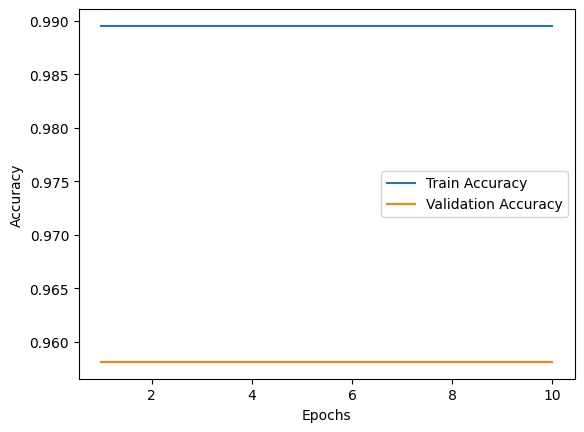

2023/12/04 15:37:57 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under mlflow-artifacts:/25/724df728501a4d96a146bdb216a69efb/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.


In [87]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# mlflow 로깅 시작
with mlflow.start_run(experiment_id=exp_id):
    # 모델 학습
    model = KNeighborsClassifier(n_neighbors=3)

    # 학습 곡선을 그릴 때 사용할 리스트
    train_accuracy_list = []
    val_accuracy_list = []

    for epoch in range(1, 11):  # 예시로 10 에포크까지 수행
        # 모델 학습
        model.fit(x_train.reshape(-1, 28 * 28), y_train)

        # 훈련 데이터에 대한 예측
        y_train_pred = model.predict(x_train.reshape(-1, 28 * 28))
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_accuracy_list.append(train_accuracy)

        # 검증 데이터에 대한 예측
        y_val_pred = model.predict(x_val.reshape(-1, 28 * 28))
        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_accuracy_list.append(val_accuracy)

        # mlflow에 메트릭 로깅
        mlflow.log_metric("train_accuracy", train_accuracy, step=epoch)
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

    # 학습 곡선 시각화
    plt.plot(range(1, 11), train_accuracy_list, label="Train Accuracy")
    plt.plot(range(1, 11), val_accuracy_list, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # mlflow에 모델 정보 로깅
    mlflow.sklearn.log_model(model, "model")


* 예측 및 검증

In [129]:
y_test_pred = model.predict(x_val.reshape(-1, 28 * 28))

# 정확도 계산 및 출력
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy}")

# 다른 성능 지표 출력 (예: 분류 보고서)
report = classification_report(y_test, y_test_pred)
print("Classification Report:\n", report)

40/40 [==============================] - 0s 1ms/step


ValueError: Found input variables with inconsistent numbers of samples: [1600, 1280]

## 4.모델 사용하기
* 팀에서 1명만 mlflow server ui에 접속하여 
    * model_## 의 각 버전 중 성능이 가장 좋은 버전을 production으로 상태변경
* 팀원들은 각자 운영모델 로딩하고, 사용해보기
    * test 셋으로 예측 및 평가
    * test image 하나를 불러와서 예측

### (1) 운영모델 로딩

In [97]:
model_uri = "models:/model_14/production" 
model_p = mlflow.keras.load_model(model_uri)

2023/12/04 15:41:02 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


### (2) test 데이터로 예측하고 평가

In [98]:
pred = model_p.predict(x_val)
pred_1 = pred.argmax(axis=1)

50/50 [==============================] - 0s 2ms/step


In [99]:
print(accuracy_score(y_val, pred_1))
print('-'*60)
print(confusion_matrix(y_val, pred_1))
print('-'*60)
print(classification_report(class_names[y_val], class_names[pred_1]))

0.969375
------------------------------------------------------------
[[72  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 69  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 56  0  0  0  0  0  0  0  2  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 65  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 62  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 56  1  0  0  0  0  1  0  0  3  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 62  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 72  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0 63  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  

### (2) 이미지 로딩해서 사용하기
* 과제1 코드 참조

In [100]:
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

In [101]:
# 파일 열기
path = 'test image/'
file = 'v.png'
filename = path + file
img = cv2.imread(filename , cv2.IMREAD_GRAYSCALE)

# 크기 조절하기
img = cv2.resize(img, (28, 28))

# 입력데이터 형식을 갖추기
test_sign = img.reshape(1,28,28,1)

test_sign = test_sign / 255.

pred = model_p.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])

1/1 [==============================] - 0s 66ms/step
['v']
